# APS1070
#### Lab 2 - Anomaly Detection Algorithm using Gaussian Mixture Model 
**Deadline: Feb 14, 23:59 - 10 points**

Please fill out the following:


*   Name: **Shashank Iyer**
*   Student Number: **1004859806**

##**Marking Scheme:**

This project is worth **10 marks** of your final grade.

**One (1) mark** of the lab is dedicated to **vectorized coding**. If you need to write a loop in your solution, think about how you can implement the same functionality with vectorized operations. Try to avoid loops as much as possible (in some cases loops are inevitable).

This notebook is composed of two sections, a Tutorial, and an Exercise. 

The TAs in the lab will help you to complete your tutorial (Although no mark is assigned to the **tutorial** compeleting that section is **mandatory**). 

**The exercise** section is worth **9 points**.

##**Important Note:**

1] Please **write answers** for the Tutorial & Exercise in the **blanks provided**.

2] Start lab early so that you understand concepts in Tutorial well & get enough time to implement exercise  

3] It is important to **complete and run the tutorial part** of the notebook. Make sure you complete both, tutorial as well as exercise part.
 
4] Provide a graphical representation of data wherever necessary.  


##Tutorial

In this part of the assignment, we will implement an anomaly detection algorithm using the Gaussian model to detect anomalous behavior in a 2D dataset first and then a high-dimensional dataset.

Loading relevant libraries and the dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt


from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=1,
                       cluster_std=0.60, random_state=0)
X_append, y_true_append = make_blobs(n_samples=10,centers=1,
                                    cluster_std=5,random_state=0)
X = np.vstack([X,X_append])
y_true = np.hstack([y_true, [1 for _ in y_true_append]])
X = X[:, ::-1] # flip axes for better plotting
plt.scatter(X[:,0],X[:,1],marker="x");

Here we've manufactured a dataset where some points are visibly outliers from the main distribution.

We can see this from looking at the plot, but how do we robustly identify the outliers? 

That's where a Gaussian estimation comes in. For this dataset, we only need a single Gaussian, for which we are gonna calculate the mean and standard deviation. Then, we're able to find the points that don't seem likely to have originated from that distribution - these are our outliers!

First, we need to calculate the mean and variance for our data. Complete the function below to generate these values using these formulas:

$$\mu = \frac{1}{m} \sum_{i=1}^{m}X_i$$

$$\sigma^2 = \frac{1}{m} \sum_{i=1}^{m}(X_i-\mu)^2$$

In [2]:
def estimateGaussian(X):
    """
     This function estimates the parameters of a Gaussian distribution using the data in X
    """
    
    m = X.shape[0]
    
    #compute mean of X
    sum_ = np.sum(X,axis=0) #axis = 0 means along columns
    mu = 1/m *sum_
    print("mean of X is", mu)
    
    # compute variance of X
    var = 1/m * np.sum((X - mu)**2,axis=0)
    print("variance of X is ", var)
    
    return mu,var
mu, sigma2 = estimateGaussian(X)

mean of X is [4.30770882 0.9756171 ]
variance of X is  [0.94147734 1.25990509]


Now, we will calculate for each point in X, the probability of the distribution $N(\mu,\sigma^2)$ generating that point randomly. This has been completed for you, although it is important to understand how the calculation of the PDF works.

In [3]:
def multivariateGaussian(X, mu, sigma2):
    """
    Computes the probability density function of the multivariate gaussian distribution.
    """
    k = len(mu)
    
    sigma2=np.diag(sigma2)
    X = X - mu.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(sigma2)**0.5))* np.exp(-0.5* np.sum(X @ np.linalg.pinv(sigma2) * X,axis=1))
    return p
p = multivariateGaussian(X, mu, sigma2)
print(p) #has only one column which states the probability of the point to be in that cluster

[1.14372564e-01 1.34958961e-01 1.43612050e-01 1.42299087e-01
 9.13712186e-02 8.55941312e-02 4.68240258e-02 1.21375203e-01
 1.02431905e-01 1.15288577e-01 7.86816997e-02 1.45340735e-01
 1.39595203e-01 1.22607393e-01 1.30647273e-01 1.38104619e-01
 1.42770647e-01 8.87545860e-02 1.29903618e-01 1.27032472e-01
 1.41351478e-01 1.28275607e-01 1.33684728e-01 1.42781106e-01
 9.32548041e-02 1.40465740e-01 1.16482935e-01 3.26217842e-02
 1.27768034e-01 1.40703489e-01 1.31726540e-01 5.68406205e-02
 1.43043322e-01 1.36223637e-01 1.13402764e-01 9.72356144e-02
 9.48531746e-02 1.33446142e-01 1.21499229e-01 4.97153521e-02
 1.09486962e-01 1.04598457e-01 1.33181817e-01 1.28145276e-01
 1.21108955e-01 9.37073350e-02 1.34444713e-01 1.45205701e-01
 1.33931685e-01 1.06246973e-01 1.39179756e-01 7.44308998e-02
 9.90408123e-02 8.95211071e-02 5.32404834e-02 8.78335694e-02
 1.43159611e-01 5.50347568e-02 5.33613370e-02 1.07679511e-01
 1.18411090e-01 1.42878452e-01 1.09469533e-01 4.97312568e-02
 1.40974086e-01 1.437390

Now that we have the probability of each point in the dataset, we can plot these on the original scatterplot:

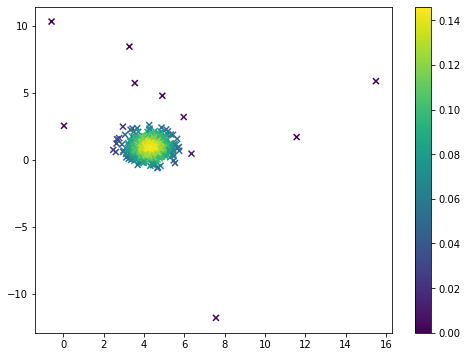

In [4]:
plt.figure(figsize=(8,6)) #to increase the figure size of the plot
plt.scatter(X[:,0],X[:,1],marker="x",c=p,cmap='viridis'); #c and cmap used to make the colors in a gradient range
plt.colorbar(); #display the color bar of the gradient colors indicating the probability density

We're getting closer to the point where we can programmatically  identify our outliers for a single Gaussian distribution. The last step is to identify a value for $p$, below which we consider a point to be an outlier. We term this $\epsilon$.

In [5]:
#Choose a value for epsilon

epsilon = 0.015 #epsilon is the minimum probability density that is required for a point to be considered nominal (not an anomaly)

Now we'll highlight on the scatter plot all points that are below $\epsilon$:

[400 401 402 403 404 405 406 407 408 409]


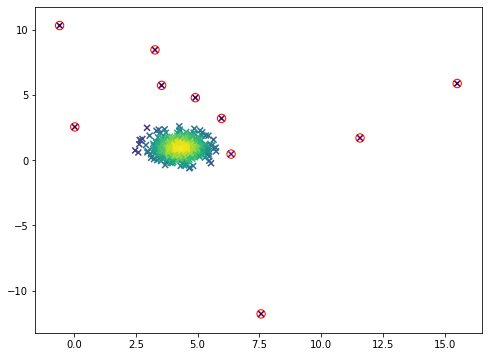

In [6]:
plt.figure(figsize=(8,6))
plt.scatter(X[:,0],X[:,1],marker="x",c=p,cmap='viridis');
# Circling of anomalies
outliers = np.nonzero(p<epsilon)[0] #returns the row index of the atleast condittion mentioned p<epsilon from the array p
print(outliers) #prints the row index of the outliers
plt.scatter(X[outliers,0],X[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);

What value of epsilon did you choose? Why? **The epsilon value chosen was 0.015, and this was done arbitrarily. However, it was important to choose a low value as the p values we got for each data point in the X1 and X2 columns were also low. Hence, this made the process of removing outliers easier.** 

Play around with different values until you're happy with the plot above. 

We can additionally look at our model's classification performance another way. By sorting the points ascending by their probability, and classifying the first $k$ points as anomalous, we can determine the model's precision@k. Implement this in the cell below. 

* What is the highest value of K for which we get a precision of 1.0? **K = 10**
* What is the precision for K=4? **1.0**

In [7]:
from sklearn.metrics import precision_score

for i in range(0,15):
     mn = sorted(p)[i]
     sc = precision_score( y_true,1*(p<=mn))
     print('K is ',i+1, ', precision is', sc)


K is  1 , precision is 1.0
K is  2 , precision is 1.0
K is  3 , precision is 1.0
K is  4 , precision is 1.0
K is  5 , precision is 1.0
K is  6 , precision is 1.0
K is  7 , precision is 1.0
K is  8 , precision is 1.0
K is  9 , precision is 1.0
K is  10 , precision is 1.0
K is  11 , precision is 0.9090909090909091
K is  12 , precision is 0.8333333333333334
K is  13 , precision is 0.7692307692307693
K is  14 , precision is 0.7142857142857143
K is  15 , precision is 0.6666666666666666


You may have noticed that in this example, we are training and testing on the _entire_ dataset. This is absolutely not standard practice! You should _always_ split into a training and testing set. However, the reason that we can get away with this here is that we don't actually use labels at all during training - this is an _unsupervised_ machine learning task. Unsupervised learning methods are beneficial for anomaly detection because in the real world (i.e. testing!) we might come across types of outliers that we didn't see during training. We want to use a method that can handle this, and unsupervised methods are often better suited to this type of domain.

For the next section, we'll move to a Mixture of Gaussian models. Take a look at the following dataset:

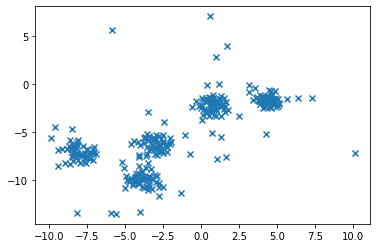

In [8]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
X, y_true = make_blobs(n_samples=400, centers=5,
                       cluster_std=0.60, random_state=1)
X_append, y_true_append = make_blobs(n_samples=50,centers=5,
                                    cluster_std=5,random_state=1)
X = np.vstack([X,X_append])
y_true = np.hstack([[0 for _ in y_true], [1 for _ in y_true_append]])
X = X[:, ::-1] # flip axes for better plotting

X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.33, random_state=1, shuffle=True)

plt.scatter(X_train[:,0],X_train[:,1],marker="x");

Okay, we have more than one cluster centre now. So what? Let's just ignore that and use the same model as before. 

* What is the precision for k=1 in the cell below? **1.0**
* k=10? **0.9**
* k=100? **0.13**

mean of X is [-1.83507767 -5.34263936]
variance of X is  [18.71750414 12.12645659]
K is  1 , precision is 1.0
K is  2 , precision is 1.0
K is  3 , precision is 1.0
K is  4 , precision is 1.0
K is  5 , precision is 1.0
K is  6 , precision is 1.0
K is  7 , precision is 1.0
K is  8 , precision is 1.0
K is  9 , precision is 1.0
K is  10 , precision is 0.9
K is  11 , precision is 0.8181818181818182
K is  12 , precision is 0.75
K is  13 , precision is 0.7692307692307693
K is  14 , precision is 0.7857142857142857
K is  15 , precision is 0.7333333333333333
K is  16 , precision is 0.6875
K is  17 , precision is 0.6470588235294118
K is  18 , precision is 0.6111111111111112
K is  19 , precision is 0.5789473684210527
K is  20 , precision is 0.55
K is  21 , precision is 0.5238095238095238
K is  22 , precision is 0.5
K is  23 , precision is 0.4782608695652174
K is  24 , precision is 0.4583333333333333
K is  25 , precision is 0.44
K is  26 , precision is 0.4230769230769231
K is  27 , precision is 0.4

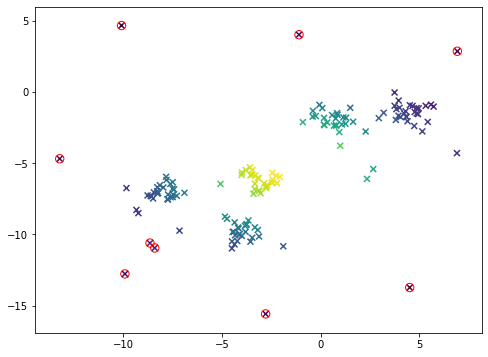

In [9]:
mu, sigma2 = estimateGaussian(X_train)
p = multivariateGaussian(X_test, mu, sigma2)
plt.figure(figsize=(8,6))
plt.scatter(X_test[:,0],X_test[:,1],marker="x",c=p,cmap='viridis');
outliers = np.nonzero(p<0.001)[0]
plt.scatter(X_test[outliers,0],X_test[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);

from sklearn.metrics import precision_score
for i in range(len(p)):
     mn = sorted(p)[i] #to sort the probability density from lowest to largest and consider first i lowest densities as outliers
     sc = precision_score( y_test,1*(p<=mn))# 
     print('K is ',i+1, ', precision is', sc)

Uh oh. This model performs terribly. It's fit the mean to a section of space where we don't have _any_ points, and it has absolutely no idea which points are outliers! This was probably pretty obvious to you though. We need to move to a Mixture of Gaussians model - one in which we use multiple Gaussians to fit the data. We'll use `sklearn.mixture.GaussianMixture` to do this - or rather you will! Use the documentation, found [here](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture) to initialise and fit a `GaussianMixture` object called `gm` in the cell below.

In [10]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components = 5, #5 components as in the X_train we have 5 centers in the data
                    covariance_type = 'full', random_state=0, ) #'full' means each component has its own general covariance matrix
gm.fit(X_train) #to train the gaussian mixture with X_train

p = gm.predict_proba(X_test)# creates the probability of a point being in each of the 5 clusters
print(p.shape)

(149, 5)


Now we can use the method `gm.score_samples()` which gives a score based on how likely a point is to have been generated by any cluster:

array([ -4.17649083,  -5.83596798,  -3.51699613,  -3.66046779,
        -4.17037173,  -4.13690423,  -3.23218358,  -3.80763763,
        -3.4222668 ,  -4.18441578,  -3.17229053,  -3.84099701,
        -4.12698981,  -3.84504974,  -8.52173288,  -3.37261619,
        -3.94206657,  -3.25055041,  -4.55754813,  -4.26240418,
        -3.67979038,  -3.5286204 ,  -8.37520838,  -4.17661908,
        -4.17850787,  -4.65067984,  -3.23213568,  -5.03895606,
        -4.20096053,  -3.99798884,  -4.14013116,  -3.2981905 ,
        -3.94567493,  -4.3371146 ,  -4.14993318,  -4.32886761,
        -4.59001642,  -3.30940836,  -4.13913447,  -4.02558726,
        -3.49963565,  -3.04436382,  -4.45531007,  -3.87448899,
        -4.11451564,  -7.61347274,  -3.83626162,  -3.1063221 ,
        -3.94556569,  -4.24408077,  -7.11227013,  -4.45365925,
        -4.73476314,  -3.80388391,  -3.11088657,  -2.98090391,
        -5.21121189,  -3.798064  ,  -4.35865846,  -5.40751824,
        -3.14675853,  -3.30745109,  -3.06713804,  -3.10

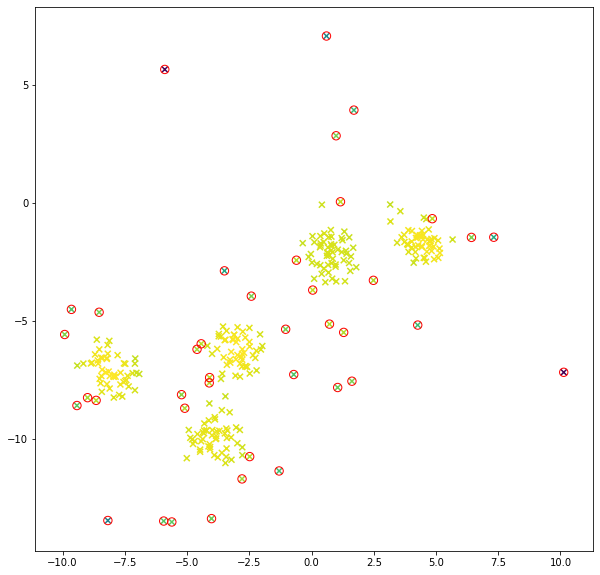

In [11]:
plt.figure(figsize=(10,10))
c = gm.score_samples(X_train)
plt.scatter(X_train[:,0],X_train[:,1],c=gm.score_samples(X_train),cmap='viridis',marker='x')

threshold= -4.8

outliers = np.nonzero(c<threshold)[0]
plt.scatter(X_train[outliers,0],X_train[outliers,1],marker="o",facecolor= "none",edgecolor="r",s=70)
c

What is the variable "`threshold`"? **threshold is the same as epsilon and it is useful when trying to identify the outlier data points as it would be used as a reference point to compare the values that are generated from score_samples and it is negative because the X values in our dataset are negative**
 
Now we can use the method `gm.predict_proba()` to spot the points in each of the clusters.

In [12]:
Non_Outliers=np.nonzero(c>=threshold)[0]
X_t=X_train[Non_Outliers]

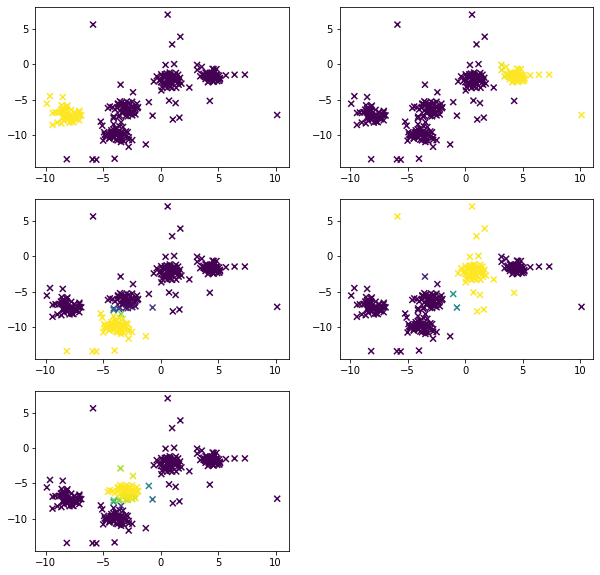

In [13]:
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(3,2,i+1)# subplot to determine the rows (3) and columns (2) to arrange the layout of multiple graphs. i+1 is the number at which each the graph should appear
    plt.scatter(X_train[:,0],X_train[:,1],c=gm.predict_proba(X_train)[:,i],cmap='viridis',marker='x')

1] What do functions `gm.score_samples()` and `gm.predict_proba()` return? **gm.score_samples() gives a score based on how likely a point is to have been generated by any cluster/gives the weighted log probabilities for each sample and gm.predict_proba() returns the probability of each data point being in any of the five clusters** 

2] Why it was important to run them in above sequence? **It is very important to run gm.score_samples() before gm.predict_proba() because .score_samples() gives the log probability of each point which is compared to the threshold value in order to eradicate all the outliers. While on the other hand, .predict_proba() gives the probability of a point belonging to any of the 5 clusters. Hence, getting rid of outliers before predictng the probability of a point to belong to a cluster is very important, otherwise we would never know whether or not it is a true representation of the data**

3] What is the difference between the two function? **The difference between the two functions is that .score_samples() gives the log prob which is the score/likelihood of a point to be in the cluster based on the distribution. This is compared to the threshold value to remove outliers. On the other hand, .predict_prob() gives the probability of a point belonging to any of the 5 clusters**


Our Mixture of Gaussians model is powerful! Not only is it unsupervised, it can both classify points into one of the K clusters we have, _and_ it can help us with our ultimate goal of identifying outlier points! We can do this by finding the points that no cluster wants to claim for itself.

In the cell below, complete the code and calculate these values and then compute precision@k for k=1, 10, and 100. The ROC curve code has been completed for you. 

* Is this model better or worse performing than the previous? **The model is better performing because when we compare the precision scores of this model for k=1,10 & 100 we get values such as 1, 1 & 0.18 which is better than the precision scores we got for the previous model which were 1, 0.9 and 0.13**
* Why might that be? **The current model is better than the previous one as it takes into account the possibility of multivariate gaussian clusters to calculate the outliers. When compared to the test data, the precision score is high because of the increased number of true positives as compared to the true positive labels**

For a k of  1  the precision is  1.000  and the recall is  0.056
For a k of  10  the precision is  1.000  and the recall is  0.556
For a k of  100  the precision is  0.180  and the recall is  1.000
(149,) (149,)


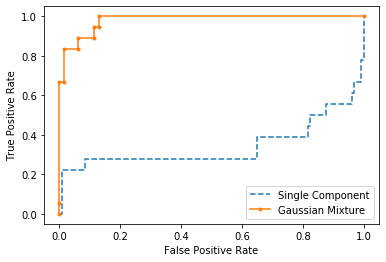

In [14]:
k=p.shape[0]
i=0
j=0
while i<k:
  while j<5:
    p[i,j] = 1 - p[i,j]
    j=j+1
  i=i+1
p=np.subtract(p,1)
p=np.prod(p,axis=1)
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

#This part outputs the precision and recall on the test set

#score_samples will compute the weighted log probabilities for each sample
p_gm = gm.score_samples(X_test) 

#Complete code below
for i in [1,10,100]: 
   #sort the points by probability, as before
   mn_gm = sorted(p_gm)[i]
   #compare y_test labels to our picks using precision
   precision = precision_score(y_test, p_gm < mn_gm) #Here, we compare y_test labels to our picks using precision
   #compare y_test labels to our picks using recall
   recall = recall_score(y_test, p_gm < mn_gm) #Here, we compare y_test labels to our picks using recall
   #print precision and recall three times
   print('For a k of ',i,' the precision is ', '%.3f' % precision,' and the recall is ', '%.3f' % recall) #We print precision and recall three times

#This part computes the ROC curves for both models like we talked about in class

print(p.shape, y_test.shape)
from sklearn.metrics import roc_curve
from matplotlib import pyplot
fpr_sc, tpr_sc, _ = roc_curve(y_test, 1-p)
fpr_gm, tpr_gm, _ = roc_curve(y_test, 1-p_gm)
pyplot.plot(fpr_sc, tpr_sc, linestyle = '--', label='Single Component')
pyplot.plot(fpr_gm, tpr_gm, marker='.', label='Gaussian Mixture')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()


Let's look at a dataset that motivates using a Mixture of Gaussians model: Simpsons ratings.

Everyone knows that there's a certain point when The Simpsons "got bad", but can we use a Mixture of Gaussians to find out exactly when that was?

Load up the `simpsons.pickle` file using the cell below. It contains the IMDb rating for every simpsons episode.

In [15]:
!pip install wget
import wget
wget.download('https://github.com/alexwolson/APS1070_data/raw/master/simpsons.pickle')

100% [..........................................................] 26076 / 26076

'simpsons (5).pickle'

In [16]:
#!wget https://github.com/alexwolson/APS1070_data/raw/master/simpsons.pickle
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
with open('simpsons.pickle','rb') as f:
    simpsons = pickle.load(f)
simpsons

{30: {"Bart's Not Dead": 6.2,
  'Heartbreak Hotel': 6.0,
  'My Way or the Highway to Heaven': 6.1,
  'Treehouse of Horror XXIX': 5.9,
  "Baby You Can't Drive My Car": 7.0,
  'From Russia Without Love': 6.6,
  'Werking Mom': 5.8,
  'Krusty the Clown': 6.6,
  'Daddicus Finch': 6.8,
  "'Tis the 30th Season": 6.7,
  'Mad About the Toy': 5.7,
  'The Girl on the Bus': 6.3,
  "I'm Dancing as Fat as I Can": 6.9,
  'The Clown Stays in the Picture': 6.2,
  '101 Mitigations': 6.4,
  "I Want You (She's So Heavy)": 5.8,
  'E My Sports': 6.3,
  'Bart vs. Itchy & Scratchy': 4.9,
  "Girl's in the Band": 6.2,
  "I'm Just a Girl Who Can't Say D'oh": 5.2,
  "D'oh Canada": 5.3,
  'Woo-Hoo Dunnit?': 6.0,
  'Crystal Blue-Haired Persuasion': 5.9},
 1: {'Simpsons Roasting on an Open Fire': 8.2,
  'Bart the Genius': 7.8,
  "Homer's Odyssey": 7.4,
  "There's No Disgrace Like Home": 7.7,
  'Bart the General': 8.1,
  'Moaning Lisa': 7.6,
  'The Call of the Simpsons': 7.8,
  'The Telltale Head': 7.7,
  'Life on th

Plot a histogram of the rating distribution for all Simpsons episodes. 

* What is the modal rating? **7.1**
* What is the range of ratings? **5.3**

the mode of the rating is:  [7.1]
the range of the ratings is:  5.300000000000001
max rating is:  9.3
min rating is:  4.0


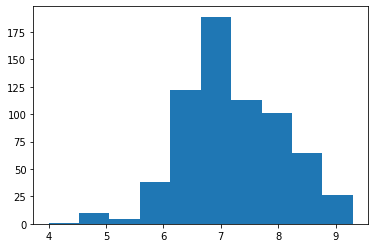

In [17]:
#converting simpsons dict to array
ratings = [] #create empty array to fill in the data we want
for i,j in simpsons.items(): #attaching the keys to i and values to j in the 1 level of the nested dictionary
  for i1,j1 in j.items(): #attaching the keys to i1 and values to j1 in the 2nd level of the nested dictionary
    ratings.append(j1) #appeding the values we want to the empty list 'rating'
    
ratings = np.asarray(ratings) #converting rating list into array  

plt.hist(ratings) #plotting histogram of the rating array

#calculating the mode of the ratings array
from scipy import stats
print("the mode of the rating is: ", stats.mode(ratings)[0])

#calculating the range of ratings
print("the range of the ratings is: ", np.ptp(ratings))
print("max rating is: ", np.max(ratings))
print("min rating is: ", np.min(ratings))

#simpsons


Next, use Gaussian Mixture to fit a Mixture of Gaussians to the Simpsons rating distribution. Since we are trying to distinguish between good and bad ratings, we only need 2 gaussians.

* What are the means for the two Gaussians fit by the model? **mean of good episodes =  6.726048565121413** , **mean of bad episodes =  8.231944444444444**
* What about the standard deviations? **standard deviation of good episodes =  0.5369619118444732** , **standard deviation of bad episodes =  0.3881913386876358**

(669, 1)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1

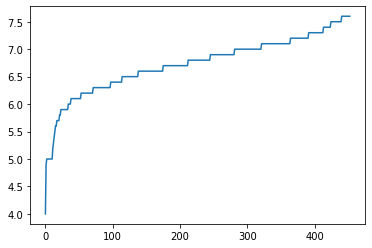

In [18]:
gm = GaussianMixture(n_components = 2, #2 components as in the X_train we have 2 centers in the data namely good and bad
                    covariance_type = 'full', random_state=0, ) #'full' means each component has its own general covariance matrix
ratings=np.reshape(ratings, (-1,1))#to make ratings a 2D array in order to put it in the gm.fit() function
print(ratings.shape)
gm.fit(ratings) #to train the gaussian mixture with ratings


ratings = np.asarray(sorted(ratings))
#print(ratings)
print(gm.predict(ratings))

goodrate = []
badrate = []

i=0
while i < ratings.shape[0]:
  if gm.predict(ratings)[i]==0:
    goodrate.append(ratings[i])
  else:
    badrate.append(ratings[i])
  i=i+1

goodrate=np.asarray(goodrate)
badrate=np.asarray(badrate)

plt.plot(goodrate)

print(" mean of good episodes = ", np.mean(goodrate))
print(" standard deviation of good episodes = ", np.std(goodrate), "\n")
print(" mean of bad episodes = ", np.mean(badrate))
print(" standard deviation of bad episodes = ", np.std(badrate), "\n")

Finally, using the `GuassianMixture.predict()` method, we can use maximum likelihood to estimate which distribution, good or bad, each episode belongs to. In the cell below, we have provided code to count the number of episodes predicted to be in the "good" distribution per season, and plot for the same.
Understand the code and answer the question.

* Where is the notable drop-off point? **Season 9**
* What is the first season with 0 good episodes? **Season 15**


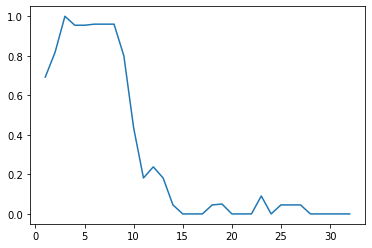

In [19]:
#Let's first associate each component with a good or bad season
if gm.means_[0,0] > gm.means_[1,0]: #True if first component is the good season (ie, higher mean)
     Good_season_index = 0
else:
     Good_season_index = 1

Xs = []
Ys = []
simpsons = dict(sorted(list(simpsons.items()), key=lambda x: x[0]))
for season, episodes in simpsons.items():
     bad = 0
     good = 0
     for episode in episodes.values():
          if gm.predict(np.array(
               episode
          ).reshape(-1,1)) == Good_season_index:
               good += 1
          else:
               bad += 1
     Xs.append(season)
     Ys.append(good/(good+bad))
plt.plot(Xs,Ys);

## Exercises

Now we are going to work with a credit card fraud dataset (more detail can be found [here](https://www.kaggle.com/mlg-ulb/creditcardfraud/downloads/creditcardfraud.zip/3)). This dataset contains 28 key features, which are not 
directly interpretable but contain meaningful information about the dataset.

Load up the dataset in CSV file using Pandas. The dataset is called `creditcard.csv`. Print out the first few columns of the dataset.

* How many rows are there?[0.5] **284,807**
* What features in the dataset are present aside from the 28 main features?[0.5] **'time', amount' which were not transformed by PCA, whereas 'class' is the target variable we will be predicting using the GMM**
* Why do you think the main features are given to us in this way?[0.5] **The PCA decomposition was necessary in order to normalize the data. Moreover, because this is a fraud detection use-case, it seems fair to perform PCA because of confidentiality reasons**
* Which column contains the targets? Can you figure out what the values correspond to? **The class column contains the target variable we will be predicting. 1 here stands for the transaction being fraudulent and 0 means the transaction is non-fraudulent**

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('creditcard.csv')
print(df.iloc[:11]) #print first 10 rows and 10 columns only
print("no. of rows are: ", df.shape[0])


    Time        V1        V2        V3        V4        V5        V6  \
0    0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388   
1    0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361   
2    1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499   
3    1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203   
4    2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921   
5    2.0 -0.425966  0.960523  1.141109 -0.168252  0.420987 -0.029728   
6    4.0  1.229658  0.141004  0.045371  1.202613  0.191881  0.272708   
7    7.0 -0.644269  1.417964  1.074380 -0.492199  0.948934  0.428118   
8    7.0 -0.894286  0.286157 -0.113192 -0.271526  2.669599  3.721818   
9    9.0 -0.338262  1.119593  1.044367 -0.222187  0.499361 -0.246761   
10  10.0  1.449044 -1.176339  0.913860 -1.375667 -1.971383 -0.629152   

          V7        V8        V9  ...       V21       V22       V23       V24  \
0   0.239599  0.098698  0.363787  ... -0.018307  0.277

In [22]:
#find percentage values for each class
fraud = df[df.Class==1] #storing fraud transactions in 'fraudindex' dataframe by filtering df by column 'Class' and equating it with 1

total = df.shape[0]
total_fraud = fraud.shape[0]

fraud_percent = ((total_fraud)*100)/total

print("percentage of entries in the dataset for fraud: ", "{0:.2f}".format(fraud_percent), "%")
print("percentage of entries in the dataset for no fraud: ", "{0:.2f}".format(100-fraud_percent),"%")

percentage of entries in the dataset for fraud:  0.17 %
percentage of entries in the dataset for no fraud:  99.83 %


It's always important when looking at a new dataset to figure out how many rows we have for each class.

* What is the percentage of entries in the dataset for each class? **Fraud = 0.17% & No Fraud = 99.83%**
* Is this target data balanced or unbalanced? why do you think this is so? **Imbalanced dataset - the dataset is skewed class as one class (fraud) has very less data points associated with it as compared to the no fraud class.** 
* Why might this pose a problem when methods we have looked at so far?[1] **Accuracy won't give a good picture of the classifier efficiency to predict true positives. Hence we must move to other evaluation metrics like Precision score, recall score, F1 score.**



Next, split the dataset into a training and testing set. Use a test size of one third, and set the random state to 0.

Make sure to separate out the column corresponding to the targets.

As mentioned earlier, in this lab we are going to use Gaussian distributions to model the data. To accomplish this, we are going to introduce `scipy`, a package which contains a wide variety of tools for working with scientific data in Python. Its `stats` package allows us to easily model various statistical distributions, and get information about them.

Scipy's Gaussian distribution class is called `norm`. It takes two parameters - `loc`, which corresponds to the mean of your distribution, and `scale`, which corresponds to the standard deviation.

* What are the mean and standard deviation for variable V24? Make sure to only use your training set for this. **mean for variable V24 is:  0.0003621464275780459 & standard deviation for variable V24 is:  0.6052978059122935** 

Use the code below to set up a Gaussian object for V24.

In [23]:
from scipy import stats


X = df.iloc[:,:(df.shape[1]-1)] #selecting feature data from df
y = df.iloc[:,-1] #selecting target data from df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0, shuffle=True) #why random state is 0 in the question?

# What are the mean and standard deviation for variable V24? Make sure to only use your training set for this

loc_v24 = X_train.V24.mean()
scale_v24 = X_train.V24.std()

print("mean for variable V24 is: ", loc_v24)
print("standard deviation for variable V24 is: ", scale_v24)

norm = stats.norm(loc_v24, scale_v24)





mean for variable V24 is:  0.0003621464275780459
standard deviation for variable V24 is:  0.6052978059122935


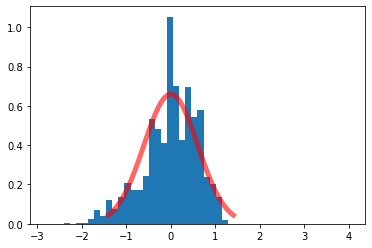

In [24]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(1, 1)
x = np.linspace(norm.ppf(0.01),
                norm.ppf(0.99), 100)
ax.plot(x, norm.pdf(x),
       'r-', lw=5, alpha=0.6, label='norm pdf')
ax.hist(X_train['V24'].values, density=True, histtype='stepfilled', bins=50);
plt.show()

We can also look at the difference in distribution for some variables between fraudulent and non-fraudulent transactions:

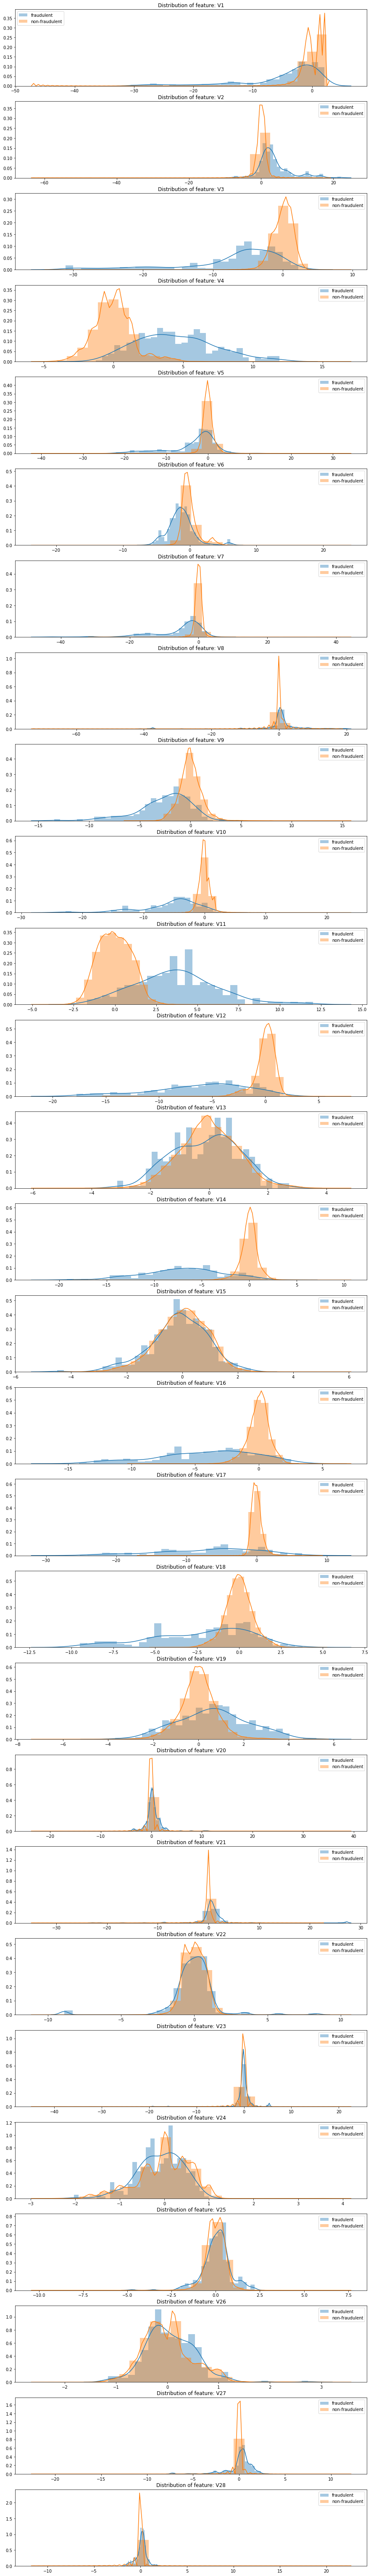

In [25]:
import matplotlib.gridspec as gridspec
import seaborn as sns
features=[f for f in df.columns if 'V' in f]
nplots=np.size(features)
plt.figure(figsize=(15,4*nplots))
gs = gridspec.GridSpec(nplots,1)
for i, feat in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.distplot(X_train[feat][y_train==1], bins=30)
    sns.distplot(X_train[feat][y_train==0],bins=30)
    ax.legend(['fraudulent', 'non-fraudulent'],loc='best')
    ax.set_xlabel('')
    ax.set_title('Distribution of feature: ' + feat)

1] Build an outlier detection model using a Mixture of Gaussians using five features with a large difference in distribution between fraudulent and non-fraudulent data. Report the precision and recall @k for k=1, 10 and 100 (on test data). Repeat this model creation process, this time selecting five features with a of your own choice, and reporting the precision and recall as above. [2]

2] What features did you choose for each model? What effect it had on the model performance? [1] **The features chosen with n_components as 5 were 'V7','V8','V12', 'V14', 'V17'. I decided to choose these features because  the probability distributions of these features are distinct enough to help the algorithm easily distinguish between fraudulent and non fraudulent data. Hence, the classifier performed well to predict the true positives with referece to the predicted positives (Precision Score) and the actual positives (Recall Score), thus giving a high precision and recall score.**

3] Organize your findings in a table or plot and describe your findings. What can you conclude about what models work best?[1] **Please refer to the ROC Curve and the tabular data beneath. As the ROC curve clearly points out that the classifier is doing a great job at maximizing the TPR/recall/sensitivity.**

For a k of  1  the precision is  0.000  and the recall is  0.000
For a k of  10  the precision is  0.900  and the recall is  0.061
For a k of  100  the precision is  0.520  and the recall is  0.354
   K Values  Precision Score  Recall Score
0         1             0.00      0.000000
1        10             0.90      0.061224
2       100             0.52      0.353741
(149,) (85443,)


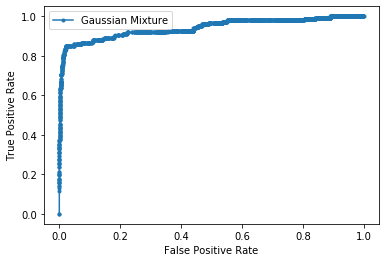

In [31]:
# To Build an outlier detection model using a Mixture of Gaussians trial 1

gm = GaussianMixture(n_components = 5, #5 components as in the X_train we have 2 centers in the data namely good and bad
                    covariance_type = 'full', random_state=0, ) #'full' means each component has its own general covariance matrix

training = X_train.loc[:,['V12','V18','V22', 'V14', 'V17']] ##choosing features with a distinct difference in the distribution between fraud vs no_fraud
testing = X_test.loc[:,['V12','V18','V22', 'V14', 'V17']]

gm.fit(training)

#This part outputs the precision and recall on the test set

pre1 = []
re1 = []

score_gm = gm.score_samples(testing) #score_samples will compute the weighted log probabilities for each sample
for i in [1, 10, 100]: #Let's look at 3 different k values
   mn_gm = sorted(score_gm)[i] #We sort the points by probability, as before
   precision = precision_score(y_test, score_gm < mn_gm) #Here, we compare y_test labels to our picks using precision
   pre1.append(precision)
   recall = recall_score(y_test, score_gm < mn_gm) #Here, we compare y_test labels to our picks using recall
   re1.append(recall)
   print('For a k of ',i,' the precision is ', '%.3f' % precision,' and the recall is ', '%.3f' % recall) #We print precision and recall three times

re1 = np.asarray(re1).reshape(-1,1)
pre1 = np.asarray(pre1).reshape(-1,1)  

try1 = np.hstack((pre1,re1))
try1 = pd.DataFrame(try1)
try1.insert(0, "k Value", [1,10,100])
try1.columns = ['K Values', 'Precision Score', 'Recall Score']
print(try1)

#This part computes the ROC curves

print(p.shape, y_test.shape)
from sklearn.metrics import roc_curve
from matplotlib import pyplot
fpr_gm, tpr_gm, _ = roc_curve(y_test, 1-score_gm)
pyplot.plot(fpr_gm, tpr_gm, marker='.', label='Gaussian Mixture')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()


For a k of  1  the precision is  0.000  and the recall is  0.000
For a k of  10  the precision is  0.700  and the recall is  0.048
For a k of  100  the precision is  0.530  and the recall is  0.361
   K Values  Precision Score  Recall Score
0         1             0.00      0.000000
1        10             0.70      0.047619
2       100             0.53      0.360544
(149,) (85443,)


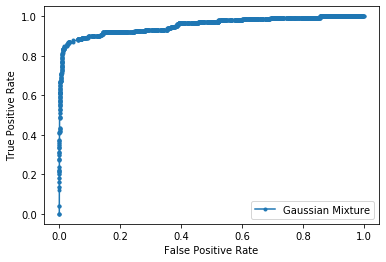

In [32]:
# To Build an outlier detection model using a Mixture of Gaussians trial 2

gm = GaussianMixture(n_components = 5, #5 components as in the X_train we have 2 centers in the data namely good and bad
                    covariance_type = 'full', random_state=0, ) #'full' means each component has its own general covariance matrix

training = X_train.loc[:,['V7','V8','V12', 'V14', 'V17']] ##choosing features with a distinct difference in the distribution between fraud vs no_fraud
testing = X_test.loc[:,['V7','V8','V12', 'V14', 'V17']]

gm.fit(training)

#This part outputs the precision and recall on the test set

pre1 = []
re1 = []

score_gm = gm.score_samples(testing) #score_samples will compute the weighted log probabilities for each sample
for i in [1, 10, 100]: #Let's look at 3 different k values
   mn_gm = sorted(score_gm)[i] #We sort the points by probability, as before
   precision = precision_score(y_test, score_gm < mn_gm) #Here, we compare y_test labels to our picks using precision
   pre1.append(precision)
   recall = recall_score(y_test, score_gm < mn_gm) #Here, we compare y_test labels to our picks using recall
   re1.append(recall)
   print('For a k of ',i,' the precision is ', '%.3f' % precision,' and the recall is ', '%.3f' % recall) #We print precision and recall three times

re1 = np.asarray(re1).reshape(-1,1)
pre1 = np.asarray(pre1).reshape(-1,1)  

try2 = np.hstack((pre1,re1))
try2 = pd.DataFrame(try2)
try2.insert(0, "k Value", [1,10,100])
try2.columns = ['K Values', 'Precision Score', 'Recall Score']
print(try2)

#This part computes the ROC curves

print(p.shape, y_test.shape)
from sklearn.metrics import roc_curve
from matplotlib import pyplot
fpr_gm, tpr_gm, _ = roc_curve(y_test, 1-score_gm)
pyplot.plot(fpr_gm, tpr_gm, marker='.', label='Gaussian Mixture')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()


In [33]:
print("Results for the 1st iteration are: \n", try1 )
print("\n\nResults for the 2nd iteration are: \n", try2 )

Results for the 1st iteration are: 
    K Values  Precision Score  Recall Score
0         1             0.00      0.000000
1        10             0.90      0.061224
2       100             0.52      0.353741


Results for the 2nd iteration are: 
    K Values  Precision Score  Recall Score
0         1             0.00      0.000000
1        10             0.70      0.047619
2       100             0.53      0.360544
